In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

/lustre/aoc/projects/hera/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
gitpath = '/lustre/aoc/projects/hera/jaguirre/kohn18_analysis/'
path = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/CalibratedData/LSThrs_10.5_23.0/FREQrng_530_730/'
dfile = 'zen.2457548.16700_66112.pI.HH.uvcRPCS.uvh5.UVP'
savepath = gitpath+'FigurePlotting/Plots/'
datapath = gitpath+'FigurePlotting/Data/'
days = [2457548, 2457549, 2457550, 2457551, 2457552, 2457553, 2457554, 2457555]
day_dfiles = [str(day) + '_LST_10_23_highband_pI.uvh5.UVP' for day in days]
print day_dfiles

['2457548_LST_10_23_highband_pI.uvh5.UVP', '2457549_LST_10_23_highband_pI.uvh5.UVP', '2457550_LST_10_23_highband_pI.uvh5.UVP', '2457551_LST_10_23_highband_pI.uvh5.UVP', '2457552_LST_10_23_highband_pI.uvh5.UVP', '2457553_LST_10_23_highband_pI.uvh5.UVP', '2457554_LST_10_23_highband_pI.uvh5.UVP', '2457555_LST_10_23_highband_pI.uvh5.UVP']


In [3]:
# This generates each day as its own UVPSpec file that you can just load in so you don't have to
#spend time on the select function when rebooting the notebook

# Only re-run if you've re-processed the data

reprocess_data = False
if reprocess_data:

    uvp_all = hera_pspec.UVPSpec()
    uvp_all.read_hdf5(path + dfile)
    times = uvp_all.time_avg_array

    def select_times(times, day):
        return np.unique(times[times.astype(int)==day])[:-1]
        #note that we throw out the last one of every day since for a few days it came out that the time samples multiplied
        #together were the last of one day and the first of the next. these were saved as things like 2457548.9...

    day_times = [select_times(times, day) for day in days]

    for day in day_times:
        print day.min(), day.max()

    uvps = [uvp_all.select(times=time_array, inplace=False) for time_array in day_times]

    #check it did what we wanted it to
    for uvp in uvps:
        print uvp.time_avg_array.min(), uvp.time_avg_array.max()

    print 'Writing: '
    for day_dfile, uvp in zip(day_dfiles, uvps):
        fpath = path + day_dfile
        print fpath
        uvp.write_hdf5(filepath=fpath, overwrite=True)

In [4]:
uvps = []
for dfile in day_dfiles:
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(path+dfile)
    uvps.append(uvp)
#check to make sure they read in properly:
for uvp in uvps:
    print uvp.time_avg_array.min(), uvp.time_avg_array.max()

2457548.1670615417 2457548.6664012005
2457549.16717992 2457549.666271027
2457550.167059274 2457550.666398932
2457551.167180929 2457551.666272036
2457552.167062831 2457552.66640249
2457553.1671831515 2457553.6662742584
2457554.167058864 2457554.6654043174
2457555.167059035 2457555.6626783116


In [5]:
blp_grps, lens, angs, tags = hera_pspec.utils.get_blvec_reds(uvps[0], bl_error_tol=1.0, match_bl_lens=True)
blps = [blp_grp[0] for blp_grp in blp_grps]
print blps

[((9, 20), (9, 20)), ((9, 31), (9, 31)), ((9, 89), (9, 89)), ((9, 10), (9, 10)), ((10, 104), (10, 104)), ((10, 64), (10, 64)), ((10, 88), (10, 88)), ((72, 96), (72, 96))]


In [6]:
for uvp in uvps:
    uvp.average_spectra(blpair_groups=blp_grps, time_avg=True, inplace=True)

In [7]:
compare_Tsys = [4000,3000,2000,1000]
P_Ns = [uvps[0].generate_noise_spectra(0, 'pI', Tsys, blpairs=blps, real=False) for Tsys in compare_Tsys]

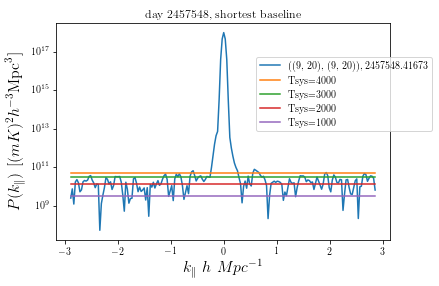

In [8]:
hera_pspec.plot.delay_spectrum(uvps[0], blpairs=[blps[0]], spw=0, pol='pI', delay=False)
for P_N, Tsys in zip(P_Ns, compare_Tsys):
    plt.plot(uvps[0].get_kparas(0), P_N[uvps[0].antnums_to_blpair(blps[0])][0], label='Tsys='+str(Tsys))
plt.legend(loc=(.6,.5))
plt.title('day 2457548, shortest baseline')
plt.show()

In [9]:
uvp = uvps[0]

In [10]:
key = (0,blps[0],'pI')
data = np.abs(uvp.get_data(key).squeeze())
kparas = uvp.get_kparas(0)
peak = data[kparas==0]

print data[kparas==0]
print data.max()

[1.02865993e+18]
1.0286599280131446e+18


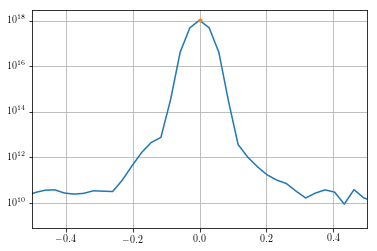

In [11]:
plt.yscale('log')
plt.plot(kparas,data)
plt.plot(0,peak,'.')
plt.xlim(-.5,.5)
plt.grid()

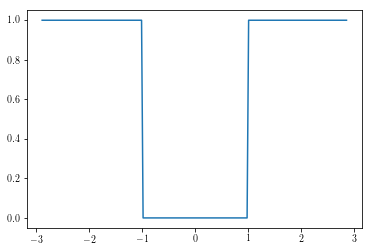

In [12]:
#we took avg over these kparas
plt.plot(kparas, np.abs(kparas)>1)
plt.show()

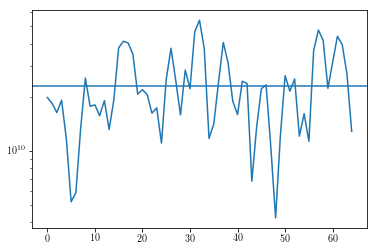

In [13]:
outside_wedge = data[np.abs(kparas>1)]
plt.plot(outside_wedge)
plt.axhline(y=np.average(outside_wedge))
plt.yscale('log')
plt.show()

In [14]:
Tsys = 2400

#each item in the list has data for one day. the data for that day is a list of data for each baseline
#length in increasing order
all_data = []
all_peaks = []
all_noise_avg = []
all_P_N = []

for uvp in uvps:
    day_data = [] #data for one day, each item is a baseline length in increasing order
    day_peaks = []
    day_noise_avg = []
    day_P_N = []
    kparas = uvp.get_kparas(0)
    
    day_P_N_dict = uvp.generate_noise_spectra(0, 'pI', Tsys, blpairs=blps, real=False)
    
    for blp in blps:
        data = np.abs(uvp.get_data((0,blp,'pI')).squeeze())
        peak = data[kparas==0].squeeze()
        avg_outside_wedge = np.average(data[np.abs(kparas>1)])
        
        day_data.append(data)
        day_peaks.append(peak)
        day_noise_avg.append(avg_outside_wedge)
        day_P_N.append(np.average(day_P_N_dict[uvp.antnums_to_blpair(blp)].squeeze()))
        
    all_data.append(day_data)
    all_peaks.append(day_peaks)
    all_noise_avg.append(day_noise_avg)
    all_P_N.append(day_P_N)

all_data = np.array(all_data)
all_peaks = np.array(all_peaks)
all_noise_avg = np.array(all_noise_avg)
all_P_N = np.array(all_P_N)

print all_data.shape
print all_peaks.shape
print all_noise_avg.shape
print all_P_N.shape

(8, 8, 200)
(8, 8)
(8, 8)
(8, 8)


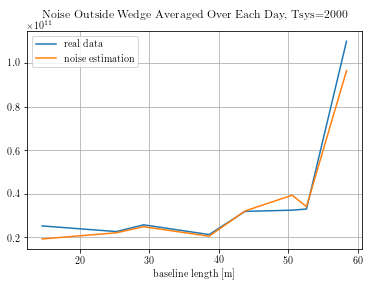

In [15]:
#playing with what Tsys should be
bl_noise_avgs = all_noise_avg.mean(axis=0) #each day has been averaged together, the list is now each baseline
bl_P_N = all_P_N.mean(axis=0)
plt.plot(lens, bl_noise_avgs, label='real data')
plt.plot(lens, bl_P_N, label='noise estimation')
plt.grid()
plt.legend()
plt.xlabel('baseline length [m]')
plt.title('Noise Outside Wedge Averaged Over Each Day, Tsys=2000', pad=15)
plt.show()

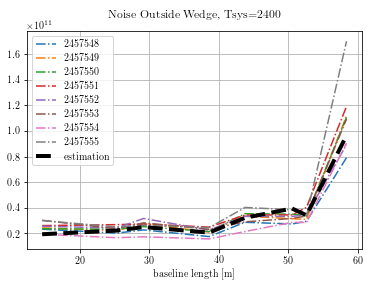

In [16]:
bl_P_N = all_P_N.mean(axis=0)
for day, noise_avg in zip(days, all_noise_avg):
    plt.plot(lens, noise_avg, label=str(day), linestyle='-.')
plt.plot(lens, bl_P_N, label='estimation', linestyle='--', color='k', linewidth=4)
plt.grid()
plt.legend()
plt.xlabel('baseline length [m]')
plt.title('Noise Outside Wedge, Tsys='+str(Tsys), pad=15)
plt.show()

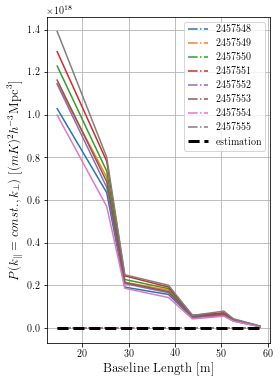

In [17]:
bl_P_N = all_P_N.mean(axis=0)
fig=plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax.set_yscale('linear')

#plot the noise for each day
for day, noise_avg in zip(days, all_noise_avg):
    ax.plot(lens, noise_avg, label=str(day), linestyle='-.')

#plot the peak for each day
for line, day_peaks in zip(ax.lines, all_peaks):
    ax.plot(lens, day_peaks, color=line.get_color())
    
#plot the noise estimation
ax.plot(lens, bl_P_N, label='estimation', linestyle='--', color='k', linewidth=3)

#finish formatting the plot
ax.grid()
ax.legend()
ax.set_xlabel('Baseline Length [m]', fontsize=13)

#label y axis
psunits = uvps[0].units
if "h^-1" in psunits: psunits = psunits.replace("h^-1", "h^{-1}")
if "h^-3" in psunits: psunits = psunits.replace("h^-3", "h^{-3}")
if "Mpc" in psunits and "\\rm" not in psunits: 
    psunits = psunits.replace("Mpc", r"{\rm Mpc}")
if "pi" in psunits and "\\pi" not in psunits: 
    psunits = psunits.replace("pi", r"\pi")
ax.set_ylabel("$P(k_\parallel=const.,k_\perp)$ $[%s]$" % psunits, fontsize=13)


fig.savefig(savepath+'noise_estimation.pdf', bbox_inches='tight')

In [18]:
#save data necessary for plotting fig 9
savename = 'fig_9_data.npz'
#np.savez(file=datapath+savename, days=days, uvps=uvps, all_data=all_data, all_peaks=all_peaks,
#         all_noise_avg=all_noise_avg, all_P_N=all_P_N)